In [1]:
import os
from tqdm import tqdm
import numpy as np
from datasets import load_dataset # huggingface datasets

num_proc = 8
num_proc_load_dataset = num_proc

/home/mainuser/anaconda3/envs/mintonano/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

from transformers import AutoTokenizer
tokenizer = enc = AutoTokenizer.from_pretrained("tokenizer/tiny_stories_tokenizer")
tokenizer.pad_token = tokenizer.eos_token


In [3]:
tokenizer.vocab_size

6400

In [4]:
tinystories_ds = load_dataset("roneneldan/TinyStories")

tinystories_ds.save_to_disk("data/tinystories")

Saving the dataset (1/1 shards): 100%|██████████| 21990/21990 [00:00<00:00, 1955450.74 examples/s]


In [5]:
if __name__ == '__main__':
    # takes 54GB in huggingface .cache dir, about 8M documents (8,013,769)
    #dataset = load_dataset("data/tinystories", num_proc=num_proc_load_dataset)
    dataset = load_dataset("roneneldan/TinyStories", num_proc=num_proc_load_dataset)
    tokenizer.pad_token = eot= tokenizer.eos_token

In [6]:
tokenizer.encode(eot)

[0]

In [7]:
tokenizer.encode(' and')

[265]

In [8]:
tokenizer.decode([723])

'and'

In [9]:
tokenizer.encode(tokenizer.eos_token)[0]

0

In [10]:
dataset['train'][:10]

{'text': ['One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.',
  'Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leav

In [11]:
def process(example):
    ids = tokenizer.encode(example['text']) # tiktoken doesn't have max seq length, HF does
    #ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    #ids = ids[:1023]
    #print(f"eos token is {tokenizer.encode(tokenizer.eos_token)}")
    ids.append(tokenizer.encode(tokenizer.eos_token)[0]) #token 1024
    #ids.append(enc.eot_token) # add the end of text token, e.g. 50256 for gpt2 bpe
    # note: I think eot should be prepended not appended... hmm. it's called "eot" though...
    out = {'ids': ids, 'len': len(ids)}
    return out

In [12]:
subs = dataset['train'].shuffle().select(range(10000)).map(process).to_pandas()

Map: 100%|██████████| 10000/10000 [00:02<00:00, 4209.46 examples/s]


In [13]:
print(subs.describe()); print(f"99.9th percentile with tokenizer of size {tokenizer.vocab_size}: {subs['len'].quantile(.999)}")

                len
count  10000.000000
mean     220.150800
std      105.290607
min        1.000000
25%      163.000000
50%      190.000000
75%      232.000000
max     1097.000000
99.9th percentile with tokenizer of size 6400: 912.0120000000024


In [14]:
subs.head()

,text,ids,len
0,"Once upon a time, there was a smart bunny who ...","[431, 447, 259, 396, 12, 399, 282, 259, 1748, ...",191
1,The sun was warm and shining as Sally made her...,"[373, 733, 282, 1159, 265, 2219, 418, 1472, 56...",237
2,Once there was a friendly girl named Laura. On...,"[431, 399, 282, 259, 1444, 446, 500, 579, 6361...",191
3,"Once upon a time, there was a little boy named...","[431, 447, 259, 396, 12, 399, 282, 259, 397, 5...",186
4,"Once upon a time, there was a little girl name...","[431, 447, 259, 396, 12, 399, 282, 259, 397, 4...",160


In [15]:
mx=subs['len'].max()
mx

1097

In [16]:
longest=subs[subs.len==mx]['text']

In [17]:
subs[subs.len==mx]['ids'].values[0]

array([1137,  265,  475, ...,  769,  259,    0])

In [18]:
tokenizer.decode(subs[subs.len==mx]['ids'].values[0])

'Anna and Ben are playing with their toy cars. They like to make them go fast and make loud noises. Anna has a red car and Ben has a blue car. They also have some stickers that look like licenses. They want to put them on their cars to make them look real.\n\n"Look, I have a license for my car!" Anna says, showing Ben her sticker. "It says Anna and has a picture of a flower. It is very pretty."\n\n"That\'s nice," Ben says. "But I have a license for my car too. It says Ben and has a picture of a star. It is very cool."\n\nThey both attach their licenses to their cars with some tape. They are very proud of their cars.\n\n"Let\'s race!" Anna says. "We can see whose car is faster."\n\n"OK," Ben says. "But I know my car is faster. It has a star on it."\n\nThey line up their cars on the floor and get ready to push them. They count to three and then push their cars as hard as they can.\n\n"Go, go, go!" Anna and Ben shout.\n\nTheir cars zoom across the floor. They are very close. Anna and Ben 

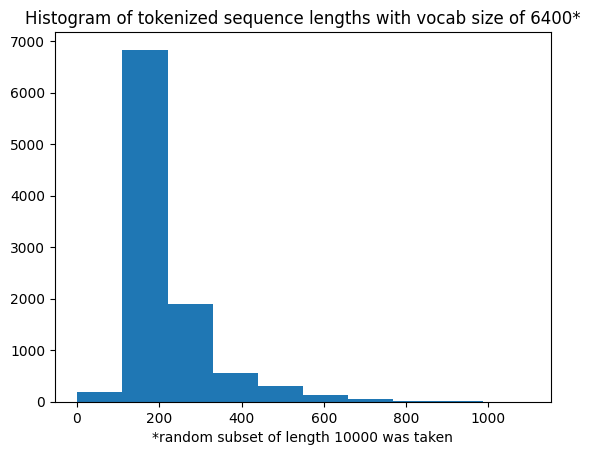

In [21]:
hst=subs['len'].hist()
hst.set_title(f'Histogram of tokenized sequence lengths with vocab size of {tokenizer.vocab_size}*')
hst.set_xlabel("*random subset of length 10000 was taken")
hst.grid(False)

In [20]:
longest.values[0]

'Anna and Ben are playing with their toy cars. They like to make them go fast and make loud noises. Anna has a red car and Ben has a blue car. They also have some stickers that look like licenses. They want to put them on their cars to make them look real.\n\n"Look, I have a license for my car!" Anna says, showing Ben her sticker. "It says Anna and has a picture of a flower. It is very pretty."\n\n"That\'s nice," Ben says. "But I have a license for my car too. It says Ben and has a picture of a star. It is very cool."\n\nThey both attach their licenses to their cars with some tape. They are very proud of their cars.\n\n"Let\'s race!" Anna says. "We can see whose car is faster."\n\n"OK," Ben says. "But I know my car is faster. It has a star on it."\n\nThey line up their cars on the floor and get ready to push them. They count to three and then push their cars as hard as they can.\n\n"Go, go, go!" Anna and Ben shout.\n\nTheir cars zoom across the floor. They are very close. Anna and Ben 

In [32]:
assert tokenizer.decode(tokenizer.encode(subs.loc[0,['text']].values[0])) == subs.loc[0,['text']].values[0], 'tokenization does not match'

In [29]:
subs.loc[1000,['text']].values[0] # in original dataset

'Once upon a time, there was a gentle rabbit. He lived in a forest full of trees and delicious carrots. Every day he would search for yummy carrots to eat.\n\nOne day, he found a special carrot - it was bigger and juicier than any he\'d ever seen before. He was so happy he couldn\'t wait to take a big bite out of it. But then a voice came from the carrot.\n\n"Who are you?" it asked.\nThe rabbit was very surprised - he had never heard a carrot talk before! He answered, telling the carrot his name.\n\nThe carrot thanked him and said, "I am the Magic Carrot. If you answer one more question correctly, you can have me as a reward! What are carrots made of?"\n\nThe rabbit thought for a moment, then answered, "Carrots are made of soil and sunshine!"\n\nThe Magic Carrot was so pleased that he gave the rabbit a big smile and said, "Well done! You have earned this delicious carrot - enjoy!"\n\nThe rabbit was delighted - he had never tasted a carrot as juicy and delicious as this one. From then o

In [34]:
assert tokenizer.decode(tokenizer.encode(subs.loc[1000,['text']].values[0])) == subs.loc[1000,['text']].values[0], 'tokenization does not match'